In [40]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import gc
import timeit
from Bio import SeqIO
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix
from scipy import sparse
import seaborn as sn
from joblib import dump, load
import multiprocessing as mp
from pandarallel import pandarallel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

%matplotlib inline
import time
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


## Import Labels


In [54]:
labels = []
def importLabels():
#     with open('./Data/shortlabels.txt', 'r') as filehandle:
    with open('./Data/labels.txt', 'r') as filehandle:


        for line in filehandle:
            # remove linebreak, if exists, which is the last character of the string
            if(line[-1] == "\n"):
                currentPlace = line[:-1]
            else:
                currentPlace = line[:]
            # add item to the list
            labels.append(currentPlace)
importLabels()

In [55]:
# print(labels)

## Import Identifiers, to be removed from kmer counts

In [56]:
# identifiers = [] # list


# with open('./Data/sequences.fasta') as fasta_file:  # Will close handle cleanly
# # with open('./Data/short.fasta') as fasta_file:  # Will close handle cleanly

#     for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
#         identifiers.append(seq_record.id)
#         sequences.append(str(seq_record.seq))
# display(identifiers)

# Import Kmer counts data  from disc

In [57]:
k=5
#Data generated with old code
# Xt = pd.read_pickle(r"D:\DataSet\Data\Generated kmers with old py code\4-5-Kmers-60,000 samples")

# data generated with Linux kmer counter code, 4-5-6-kmers
# Xt = pd.read_pickle(r"D:\DataSet\Data\Generated kmers with old py code\4-5-Kmers-60,000 samples")

X = pd.read_feather(r"D:\DataSet\MULTI\bow\df-k"+str(k)+".feather")

In [58]:
X.fillna(0, inplace=True)


# labels = []
# importLabels()

# Transform data from BagOfWords to Tf-Idf

In [66]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()

X = tfidfconverter.fit_transform(X).toarray()

In [67]:
display(X)

array([[0.04978968, 0.04382222, 0.03557708, ..., 0.02463768, 0.03285845,
        0.03870272],
       [0.02354684, 0.0186522 , 0.01863729, ..., 0.04194647, 0.02797131,
        0.04235959],
       [0.02852741, 0.01765427, 0.0458644 , ..., 0.04587816, 0.03176975,
        0.04633   ],
       ...,
       [0.02813694, 0.03830779, 0.03131767, ..., 0.01044236, 0.02437159,
        0.03163559],
       [0.01650953, 0.02452073, 0.02450113, ..., 0.02995481, 0.02451461,
        0.01924988],
       [0.03024527, 0.04192693, 0.0418934 , ..., 0.01496642, 0.04790451,
        0.03929592]])

# Feature Selection Select best features

In [47]:


selector = SelectPercentile(score_func=chi2, percentile=100) 
selector = SelectKBest(chi2, k=500)
X = selector.fit_transform(X, labels)


# Scale Data and Train

In [34]:
# max_abs_scaler = MaxAbsScaler()
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [68]:

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    labels, 
                                                    test_size = 0.20, 
                                                    random_state=42)

In [69]:
print(X_train.shape)
print(X_test.shape)

(48000, 1024)
(12000, 1024)


In [37]:
# LinearSVC?



## Select Model

In [70]:
start = time.time()

# clf = make_pipeline(StandardScaler(),GaussianNB()) ## Bad performance on kmers 4-5
clf=  make_pipeline(StandardScaler(),LogisticRegression(random_state=0, max_iter=500).fit(X_train, y_train))

# clf=  make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5, C=0.01, max_iter=2500))# Hyper Tuned

# clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))

# clf = KNeighborsClassifier(n_neighbors=4, weights='distance')

clf.fit(X_train, y_train)


end = time.time()
# total time taken
print(f"Runtime of fitting "+ str(clf)+ f"classifier is {end - start} secs")



Runtime of fitting Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=500, random_state=0))])classifier is 9.097941160202026 secs


Runtime of GridSearchCV LinearSVC (random_state=0, tol=1e-05) classifier is 10416.215190410614 secs
Best parameter after tuning: {'SVC__C': 0.01}

Warnings: C:\Users\Bassem new\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

# GridSearch SVC model

In [15]:
GridSearchCV?

In [ ]:
start = time.time()

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, n_jobs=-1, refit = True, verbose = 3)


#fitting the model for grid search
grid.fit(X_train, y_train)

end = time.time()
# total time taken
print(f"Runtime of GridSearch HyperParam tuning of "+ str(grid)+ f"classifier is {end - start} secs")


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 259.8min


In [71]:
y_pred = clf.predict(X_test)

# print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.58      0.59      0.59      5969
           1       0.59      0.58      0.59      6031

    accuracy                           0.59     12000
   macro avg       0.59      0.59      0.59     12000
weighted avg       0.59      0.59      0.59     12000



In [ ]:

# y_pred = clf.predict(X_test)

In [72]:


# print("Confusion matrix\n")
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

# pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted'))



accuracy = 0.588 
precision = 0.588 
recall = 0.587 
f1 = 0.588


array([[3538, 2431],
       [2531, 3500]], dtype=int64)

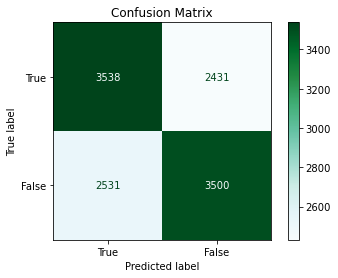

In [65]:
class_names = ['True', 'False']
disp = plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.BuGn)
disp.ax_.set_title('Confusion Matrix')
disp.confusion_matrix



In [ ]:
# sn.heatmap(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')), annot=True,cmap="OrRd")
# dump(clf, './saved/clf.joblib') 
# clf = load('./saved/clf.joblib') 